# Исследование рынка недвижимости РФ

Томашук Анна

In [1]:
# импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import t, norm
from scipy import stats as st
from scipy.optimize import curve_fit

from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LassoCV, RidgeCV

!!!!! Так как объем данных очень большой, в работе не создавались копии датасета. Если бы не было проблемы с памятью, то нужно было бы создавать копии датасета при удалении выбросов, дубликатов и так далее.

In [132]:
df = pd.read_csv('realty_18_21.csv') #загружаем файл

In [133]:
df.head()

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type
0,6050000,2018-02-19,2661,1,8,10,3,82.6,10.8,1
1,8650000,2018-02-27,81,3,5,24,2,69.1,12.0,1
2,4000000,2018-02-28,2871,1,5,9,3,66.0,10.0,1
3,1850000,2018-03-01,2843,4,12,16,2,38.0,5.0,11
4,5450000,2018-03-01,81,3,13,14,2,60.0,10.0,1


In [134]:
df.shape # определим размер датасета

(5477006, 10)

In [135]:
df.info() #изучим основную информацию о файле

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5477006 entries, 0 to 5477005
Data columns (total 10 columns):
 #   Column         Dtype  
---  ------         -----  
 0   price          int64  
 1   date           object 
 2   region         int64  
 3   building_type  int64  
 4   level          int64  
 5   levels         int64  
 6   rooms          int64  
 7   area           float64
 8   kitchen_area   float64
 9   object_type    int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 417.9+ MB


In [197]:
#изменим формат в столбце date на формат даты
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d') 

In [137]:
# в остальных столбцах заменим тип данных на int16 и float16
dtype_dict = {'price': 'int16', 'region': 'int16', 'building_type': 'int16', 'level': 'int16', 'levels': 'int16', 'rooms': 'int16', 'area': 'float16', 'kitchen_area': 'float16', 'object_type': 'int16'}
df = df.astype(dtype_dict)

Столбец rooms содержит данные типа float64, хотя по логике формат должен быть int64, как в остальных столбцах. Разберемся с проблемой.

In [138]:
# посмотрим уникальные значения по столбцу rooms
df['rooms'].unique()

array([ 3,  2,  1,  4, -1,  5,  7,  6,  8,  9, -2, 10], dtype=int16)

Были замечены отрицатльные значения в столбце rooms. -1 - это студии, а вот -2 - непонятно. Посмотрим на эти данные.

In [139]:
df.query('rooms == -2')

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type
62764,8320,2018-09-17,2843,2,22,22,-2,415.25,40.000000,11
89002,6496,2018-09-18,2661,3,1,7,-2,360.00,22.000000,1
112359,4272,2018-09-21,2661,2,2,17,-2,35.00,9.000000,1
118076,-25376,2018-09-22,81,3,3,5,-2,61.00,5.601562,1
142208,-16320,2018-09-26,81,3,3,3,-2,300.00,30.000000,1
...,...,...,...,...,...,...,...,...,...,...
5357663,-9296,2021-04-19,3019,4,4,5,-2,9.00,10.703125,1
5374584,32704,2021-04-21,2661,3,2,3,-2,9.00,25.000000,1
5392668,-22768,2021-04-24,2661,3,2,4,-2,9.00,19.703125,1
5432473,22656,2021-04-29,81,2,7,17,-2,9.00,10.703125,1


Скорее всего это двухэтажные квартиры. Учтем это при дальнейшей работе.

In [288]:
df['object_type'].unique()

array([ 1, 11], dtype=int64)

Здесь лучше сделать категориальную переменную. 1 - вторичный рынок, 0 - новостройка

In [289]:
df['object_type'] = df['object_type'].replace(11, 0)

In [290]:
df['object_type'].unique()

array([1, 0], dtype=int64)

Проверим дубликаты в новом датасете

In [140]:
# проверим пропуски
df[df.duplicated()]

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type
466,-10720,2018-09-08,9654,1,5,10,1,41.37500,10.882812,11
516,-10844,2018-09-08,9654,1,8,10,1,33.59375,5.000000,11
589,1424,2018-09-08,9654,1,3,10,1,33.59375,5.000000,1
604,21776,2018-09-08,9654,1,10,10,2,64.00000,12.000000,1
627,22496,2018-09-08,9654,1,4,10,1,33.59375,5.000000,11
...,...,...,...,...,...,...,...,...,...,...
5475660,19264,2021-05-01,3991,1,7,9,3,65.00000,8.601562,1
5475971,-32160,2021-05-01,2604,3,4,10,2,48.00000,9.000000,1
5476318,-28416,2021-05-01,2661,2,14,18,1,44.00000,10.000000,1
5476380,-22528,2021-05-01,3991,3,6,9,2,87.00000,19.500000,1


Что-то очень много дубликатов, обработаем их после исключения пропущенных значений, так как есть предположение о том, что некоторые дубликаты перестанут быть дубликатами.

In [141]:
# посмотрим на пропуски
df.isna().sum()

price                 0
date                  0
region                0
building_type         0
level                 0
levels                0
rooms                 0
area                  0
kitchen_area     253711
object_type           0
dtype: int64

In [142]:
# посмотрим на пропущенные значения
df[df['kitchen_area'].isna()]

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type
19,11600,2018-03-16,2843,3,5,5,2,51.00000,NaN,1
42,9088,2018-04-14,81,3,11,14,2,54.00000,NaN,1
78,30880,2018-06-04,4417,1,7,9,2,52.00000,NaN,1
114,16416,2018-07-12,81,3,2,9,1,37.50000,NaN,1
136,-32704,2018-07-31,2661,2,6,14,1,47.09375,NaN,1
...,...,...,...,...,...,...,...,...,...,...
5476919,-29300,2021-05-01,6543,0,7,12,-1,43.31250,NaN,11
5476924,-9070,2021-05-01,6543,0,12,12,2,59.87500,NaN,11
5476979,-11696,2021-05-01,3,2,2,11,3,96.37500,NaN,11
5476982,-31000,2021-05-01,3,2,4,23,2,59.09375,NaN,11


Как заполнить пропуски? Первое предположение, показавшееся более чем логичным - посмотреть Строительные нормы и правила (СНиП). Может там есть какая-то информация о площадях кухни.

    "СП 55.13330.2016. Свод правил. Дома жилые одноквартирные. СНиП 31-02-2001" (утв. и введен в действие Приказом Минстроя России от 20.10.2016 N 725/пр) (ред. от 10.07.2018)

    Площадь жилых комнат и вспомогательных помещений в квартирах должна быть, м , не менее:
    14 - общей жилой комнаты в однокомнатной квартире;
    16 - общей жилой комнаты в квартирах с числом жилых комнат две и более;
    8 - спальни (10 - на двух человек);
    8 - кухни;
    6 - кухонной зоны в кухне-столовой.
    В однокомнатных квартирах допускается проектировать кухни или кухни-ниши площадью не менее 5 м .


Минимальная площадь кухни для квартиры найдена по СНиПу. Посмотрим соблюдается ли СНиП в нашем датасете.

In [143]:
df.query('rooms == -1 and  kitchen_area < 5')

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type
135,-22678,2018-07-31,2661,1,1,5,-1,23.593750,4.601562,11
289,9314,2018-09-08,3,2,8,15,-1,25.593750,4.699219,11
1540,176,2018-09-08,6817,3,3,5,-1,14.000000,4.000000,1
1560,14640,2018-09-08,6817,3,3,5,-1,19.000000,4.000000,1
1666,7145,2018-09-08,6817,1,8,9,-1,23.000000,2.000000,1
...,...,...,...,...,...,...,...,...,...,...
5476863,-1624,2021-05-01,2661,3,5,6,-1,19.484375,2.000000,1
5476865,-7520,2021-05-01,2661,0,5,18,-1,25.000000,4.000000,11
5476893,-6992,2021-05-01,81,2,11,32,-1,24.000000,3.099609,1
5476939,1424,2021-05-01,3019,1,1,9,-1,16.000000,4.500000,1


In [144]:
df.query('rooms == 1 and  kitchen_area < 5')

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type
216,-8852,2018-08-31,2661,2,6,8,1,28.906250,4.800781,11
227,-20472,2018-09-04,2843,3,1,1,1,28.000000,4.000000,1
254,6960,2018-09-08,2843,2,3,3,1,17.906250,4.000000,1
314,-26256,2018-09-08,2843,2,7,9,1,31.296875,2.000000,1
362,2352,2018-09-08,2843,2,4,9,1,24.406250,3.000000,1
...,...,...,...,...,...,...,...,...,...,...
5476598,20352,2021-05-01,3991,1,1,8,1,12.703125,2.000000,1
5476637,-904,2021-05-01,3991,2,17,19,1,22.296875,2.000000,11
5476746,31416,2021-05-01,3991,3,4,20,1,33.500000,3.000000,1
5476750,9104,2021-05-01,3106,3,2,4,1,22.000000,2.000000,1


In [145]:
df.query('rooms != -1 and rooms != 1 and kitchen_area < 6')

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type
3,14992,2018-03-01,2843,4,12,16,2,38.0000,5.000000,11
51,20352,2018-04-25,2871,3,5,5,2,40.6875,5.500000,11
74,-24832,2018-05-31,1010,1,4,5,4,58.0000,5.601562,1
107,20352,2018-07-04,4417,3,2,5,2,43.6875,5.601562,1
120,16960,2018-07-19,1010,3,1,5,2,23.0000,5.000000,1
...,...,...,...,...,...,...,...,...,...,...
5476763,11600,2021-05-01,5282,4,5,5,2,44.3125,5.199219,1
5476804,-3936,2021-05-01,2922,3,6,9,2,48.0000,5.000000,1
5476925,11056,2021-05-01,9654,3,5,5,2,43.1875,5.800781,1
5476947,-7872,2021-05-01,9654,3,1,5,2,44.0000,5.000000,1


СНиП в нашем датасете не выполняется. Есть однокомнатные квартиры и студии, где площадь кухни меньше 5 м2, а также квартиры, где кухни меньше 6 м2. Есть случаи, когда при общей площади квартиры 150 м2 кухня всего 5.8 м2. Предположение исследователя: ошибка в данных, потому что непонятно, как была продана квартира не соответсвующая строительным правилам и нормам.
Значение не проходящие по СНиПу составляют около 5-6% от всего датасета, поэтому дальше для чистоты исследования исключим эти значения.

In [146]:
df = df.query('~(rooms == -1 and kitchen_area < 5)') # удалим студии, у которых кухни меньше 5 м2

In [147]:
df = df_new.query('~(rooms == 1 and kitchen_area < 5)') #удалим однокомнатные квартиры, у которых кухни меньше 5 м2

In [148]:
df= df.query('~(rooms != -1 and rooms != 1 and kitchen_area < 6)') #удалим однокомнатные квартиры, у которых кухни меньше 5 м2

Перейдем к заполнению пропущенных значений. Заполнить столбец согласно минимуму несправедливо. Попробуем посчитать по известным данным, какой процент составляет площадь кухни от общей площади квартиры.

In [149]:
(df['kitchen_area'] / df['area']).median() # берем медиану, так она более устойчива к распределению и выбросам

0.19478260869565217

Кухня составляем примерно 19.23% от площади всей квартиры. Но нужно учитывать сколько комнат в квартире. Скорее всего заполнять придется по медианному значению дифференцируя по количеству комнат.

In [150]:
df['rooms'].unique()

array([ 3,  2,  1,  4, -1,  5,  7,  6,  8,  9, -2, 10], dtype=int64)

In [151]:
# с помощью цикла посчитаем долю площади кухни к площади квартиры для каждого 
rooms_list = []
median_per_list = []

for i in df['rooms'].unique():
    data = df.query('rooms == @i')
    median_per = (data['kitchen_area'] / data['area']).median()
    rooms_list.append(i)
    median_per_list.append(median_per)


df_med = pd.DataFrame({'rooms': rooms_list, 'median_per': median_per_list})
df_med

,rooms,median_per
0,3,0.142857
1,2,0.177215
2,1,0.257732
3,4,0.117253
4,-1,0.174825
5,5,0.108108
6,7,0.098922
7,6,0.100000
8,8,0.083961
9,9,0.103670


    Хорошая идея: два уровня сделать (по комнатам и по типу дома: новостройка или вторичка). Тогда результат будет точнее и лучше.

In [152]:
# соединим два датасета между собой
df = df.merge(df_med, on='rooms', how='left')

In [153]:
# проверим всё ли получилось
df.head(1)

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type,median_per
0,6050000,2018-02-19,2661,1,8,10,3,82.6,10.8,1,0.142857


In [154]:
# заполним пропущенные значения
df['kitchen_area'] = df['kitchen_area'].fillna(df['area'] * df['median_per'])

In [155]:
# проверим всё ли получилось
df[df['kitchen_area'].isna()]

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type,median_per


Вернулся пустой датасет. Всё пропуски обработаны. Теперь хотелось бы проверить соответсвие СНиПу: для студий и однокомнатных минимум 5 м2, для других минимум 6 м2

In [156]:
df.query('rooms == 1 and  kitchen_area < 5')

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type,median_per
16407,1170000,2018-09-10,2922,3,5,9,1,18.00,4.639175,1,0.257732
22800,1420000,2018-09-11,2922,3,3,5,1,18.50,4.768041,1,0.257732
29747,1180000,2018-09-12,3230,3,3,5,1,18.00,4.639175,1,0.257732
43701,720000,2018-09-14,2843,3,1,3,1,19.00,4.896907,1,0.257732
51663,290000,2018-09-16,6171,3,2,5,1,13.00,3.350515,1,0.257732
...,...,...,...,...,...,...,...,...,...,...,...
5142805,670000,2021-04-30,3991,0,3,9,1,17.00,4.381443,1,0.257732
5148567,1700000,2021-05-01,9654,0,3,17,1,19.31,4.976804,1,0.257732
5149350,1650000,2021-05-01,9654,2,16,17,1,19.20,4.948454,1,0.257732
5153673,550000,2021-05-01,4189,3,5,5,1,18.00,4.639175,1,0.257732


Как и ожидалось, по нашим подсчетам получились кухни, которые не могут быть спроектированы впринцепи. Заполним их минимально возможной площадью по СНиПу.

In [157]:
# отредактируем кухни студий
df.loc[(df['rooms'] == -1) & (df['kitchen_area'] < 5), 'kitchen_area'] = 5

In [158]:
# отредактируем кухни однокомнатных квартир
df.loc[(df['rooms'] == 1) & (df['kitchen_area'] < 5), 'kitchen_area'] = 5

In [159]:
# отредактируем кухни других квартир
df.loc[(df['rooms'] != 1) & (df['rooms'] != -1) & (df['kitchen_area'] < 6), 'kitchen_area'] = 6

Вроде бы всё обработали и учли. Посмотрим на пропуски теперь.

In [160]:
# посмотрим на пропуски
df.isna().sum()

price            0
date             0
region           0
building_type    0
level            0
levels           0
rooms            0
area             0
kitchen_area     0
object_type      0
median_per       0
dtype: int64

С пропусками справились. Посмотрим на дубликаты, которые мы оставили на потом.

In [161]:
# проверим дубликаты в новом датасете
df[df.duplicated()]

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type,median_per
441,1300000,2018-09-08,9654,1,5,10,1,41.36,10.88,11,0.257732
488,906660,2018-09-08,9654,1,8,10,1,33.58,5.00,11,0.257732
551,1050000,2018-09-08,9654,1,3,10,1,33.58,5.00,1,0.257732
566,2250000,2018-09-08,9654,1,10,10,2,64.00,12.00,1,0.177215
588,940000,2018-09-08,9654,1,4,10,1,33.58,5.00,11,0.257732
...,...,...,...,...,...,...,...,...,...,...,...
5156606,5000000,2021-05-01,3991,1,7,9,3,65.00,8.60,1,0.142857
5156901,3900000,2021-05-01,2604,3,4,10,2,48.00,9.00,1,0.177215
5157212,5280000,2021-05-01,2661,2,14,18,1,44.00,10.00,1,0.257732
5157271,6400000,2021-05-01,3991,3,6,9,2,87.00,19.50,1,0.177215


Никаких идей с устраненией этой проблемы не нашлось, поэтому удалим дубликаты из нашего датасета.

In [162]:
# удалим дубликаты
df.drop_duplicates(inplace=True)

In [163]:
# проверим всё ли получилось
df[df.duplicated()]

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type,median_per


Посмотрим на получившийся после предобработки датасет

In [164]:
df.info() #изучим основную информацию о файле

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4944996 entries, 0 to 5157836
Data columns (total 11 columns):
 #   Column         Dtype  
---  ------         -----  
 0   price          int64  
 1   date           object 
 2   region         int64  
 3   building_type  int64  
 4   level          int64  
 5   levels         int64  
 6   rooms          int64  
 7   area           float64
 8   kitchen_area   float64
 9   object_type    int64  
 10  median_per     float64
dtypes: float64(3), int64(7), object(1)
memory usage: 452.7+ MB


Вроде бы всё хорошо. Добавим информацию из датасета region.csv

In [165]:
df_region = pd.read_csv('region.csv') #загружаем файл

In [166]:
df_region.head()

,code,reg_name
0,2661,Санкт-Петербург
1,3446,Ленинградская область
2,3,Москва
3,81,Московская область
4,2843,Краснодарский край


In [167]:
df_region.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   code      83 non-null     object
 1   reg_name  83 non-null     object
dtypes: object(2)
memory usage: 1.4+ KB


В дополнительном датасете содержится расшифровка кодов регионов. Добавим эту расшифровку в исходный датасет. Для объединения датасетов необходим один тип данных в столбцах. Изменим тип данных в столбце code на int.

In [168]:
df_region['code'] = df_region['code'].astype(int)

ValueError: invalid literal for int() with base 10: '7873, 6937'

Ошибка, возникшая при изменении типа данных, указывает на ошибку в данных. Исправим её.

In [169]:
df_region[df_region['code'].str.contains('7873, 6937')]

,code,reg_name
36,"7873, 6937",Республика Крым


In [170]:
df_region['code'] = df_region['code'].str.replace('7873, 6937', '7873')
new_row = {'code': '6937', 'reg_name': 'Республика Крым'}
df_region = df_region.append(new_row, ignore_index=True)

C:\Users\An_to\AppData\Local\Temp\ipykernel_11328\3970926288.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_region = df_region.append(new_row, ignore_index=True)


Исправили данную проблему. Попробуем снова изменить тип данных.

In [171]:
df_region['code'] = df_region['code'].astype(int)

Объединим теперь датасеты

In [172]:
# соединим два датасета между собой
df = df.merge(df_region, left_on='region', right_on='code')

# удалим столбец
df = df.drop('code', axis=1)

In [174]:
df.head(1)

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type,median_per,reg_name
0,6050000,2018-02-19,2661,1,8,10,3,82.6,10.8,1,0.142857,Санкт-Петербург


# Исследование рынка недвижимости

Величина исследования - цена за м2

Перед началом анализа нужно исследовать датасет на выбросы

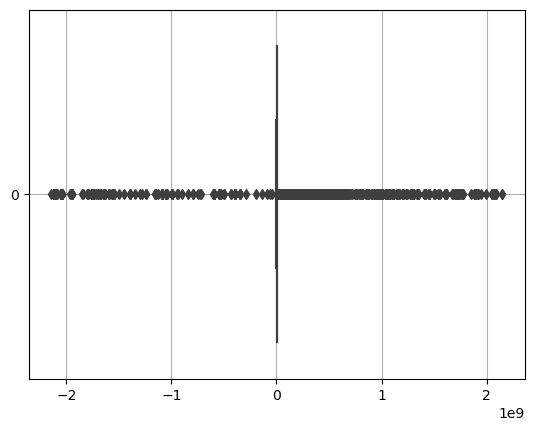

In [200]:
#построим boxplot
sns.boxplot(data=df['price'], orient='h')
plt.grid()

Данные содержат очень много выбросов, это будет создавать проблемы при дальнейшем исследовании

In [201]:
# определим значения границы усов
q75 = np.percentile(df['price'], 75)
q25 = np.percentile(df['price'], 25)
iqr = (q75 - q25)
ejection_h = q75 + iqr * 1.5
ejection_l = q25 - iqr * 1.5

print (ejection_h, ejection_l)

9498686.25 -2419211.75


In [202]:
# так как нижняя граница уса уходит в отрицательное значение, а стоимость квартиры отрицательной быть в нашем примере не может
# можем заменить нижнюю границу уса на 0

ejection_l = 0
print (ejection_h, ejection_l)

9498686.25 0


In [204]:
# определим число выбросов
n_ejection = df['price'][(df['price'] > ejection_h) | (df['price'] < ejection_l)].count()
print('Число выбросов:', n_ejection)

Число выбросов: 392408


In [205]:
# определим процент этих выбросов в нашем датасете
ejection_perc = (n_ejection / df['price'].count()) * 100
print('Процент выбросов в датасете:', ejection_perc)

Процент выбросов в датасете: 7.9354563684176895


Так как выбросы составляют примерно 8% значений от всего датасета, то их можно удалить без существенных потерь в данных.

In [224]:
#перезапишем датасет, отфильтровав его
df = df[(df['price'] > ejection_l) & (df['price'] <= ejection_h)]
df = df.reset_index(drop=True)

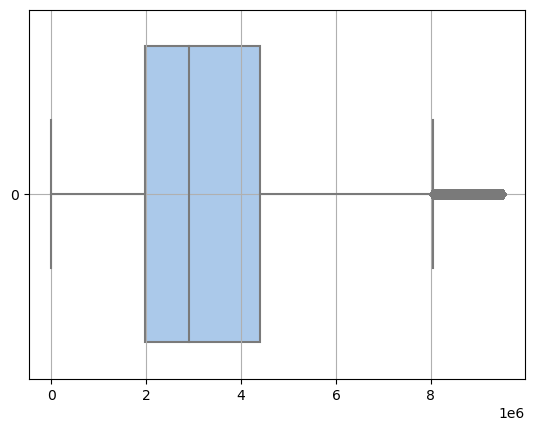

In [225]:
#проверим boxplot
sns.boxplot(data=df['price'], orient='h')
plt.grid()

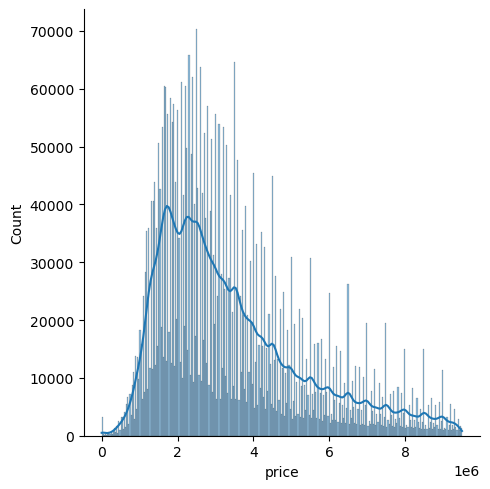

In [208]:
sns.displot(df['price'], kde=True)

Распределение не похоже на нормальное, посмотрим по QQ-plot

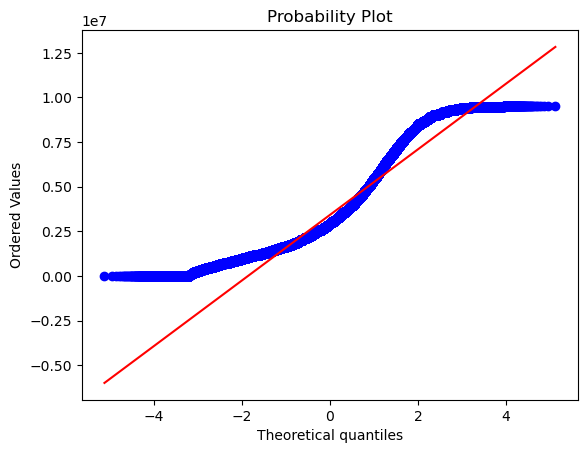

In [209]:
# построим QQ-plot
st.probplot(df['price'], dist='norm', plot=plt)
plt.show()

По графики видно, что распределение не является нормальным.  Это необходимо будет учесть в дальнейшем исследовании.

Так как величина исследования цена за м2, то необходимо рассчитать цену за м2 для каждого объекта недвижимости.

In [210]:
df['price_per_m2'] = df['price'] / df['area']

Чтобы определиться с направлением исследования, нужно выяснить от чего зависит цена за м2. Выявить тесноту связи поможет матрица корреляции. Будем исспользовать коэффициент корреляции Кендалла, так как он устойчив к выбросам и распределению.

In [220]:
# вычисляем матрицу корреляций
corr_matrix = df.corr(method='kendall')

In [291]:
# оставляем только интересующий нас столбец
price_per_m2_corr = corr_matrix['price_per_m2']
price_per_m2_corr

price            0.602598
region          -0.303273
building_type   -0.006914
level            0.182319
levels           0.273325
rooms           -0.113441
area            -0.089613
kitchen_area     0.091868
object_type      0.038684
median_per       0.117936
price_per_m2     1.000000
pur_year         0.159152
Name: price_per_m2, dtype: float64

    !!!!!!!! Для данных building_type, object_type нужно создавать фиктивные переменные по каждой категории. 
    Это не было сделано, а надо бы....)

Корреляция цены за м2 и других показателей есть, но достаточно небольшая. 
Логичнее всего будет исследовать зависимость цены за м2 от даты приобретения(date), региона (region), этажности дома (levels) и этажа квартиры (level)  

## Как менялась цена за м2 в зависимости от даты приобретения

In [233]:
df['pur_year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

In [234]:
df.head(1)

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type,median_per,reg_name,price_per_m2,pur_year,month
0,6050000,2018-02-19,2661,1,8,10,3,82.6,10.8,1,0.142857,Санкт-Петербург,73244.552058,2018,2


In [222]:
df['price_per_m2'].corr(df['pur_year'])

0.1683718395417047

Коэффициент корреляции между годом приобретения и ценой за м2 равен 0,17, то говорит о слабой связи. Но логика подсказывает, что эта связь намного теснее.

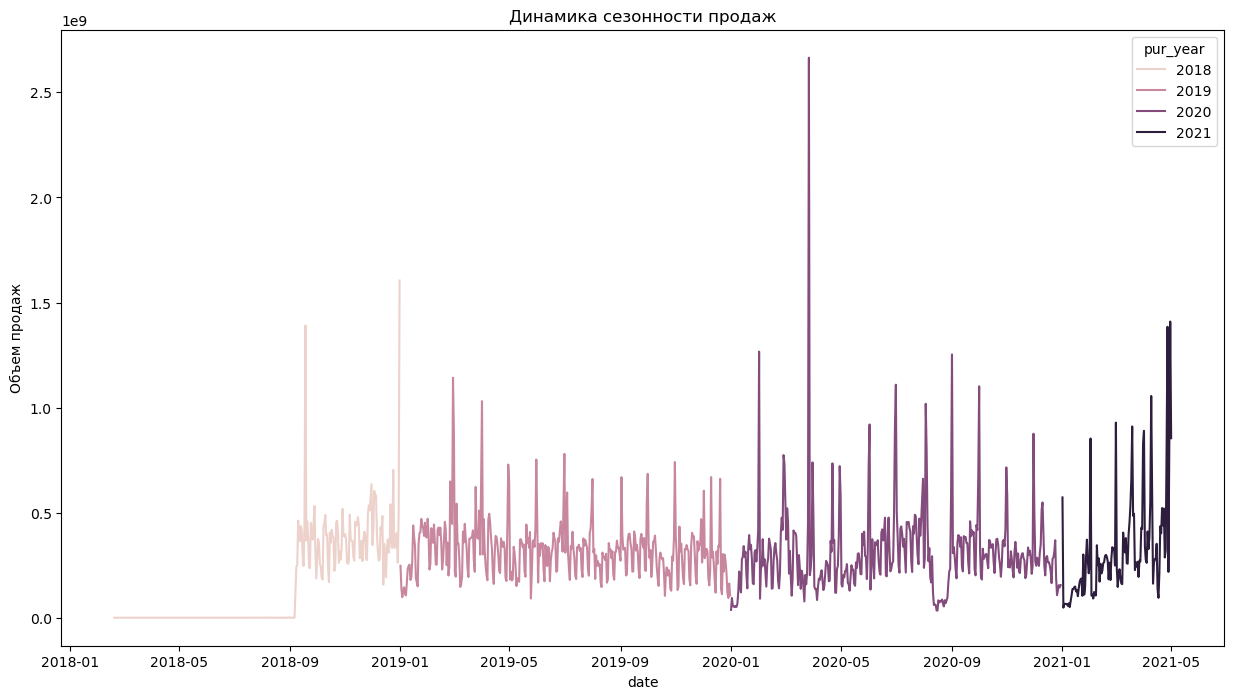

In [226]:
#визуализируем
sns.set_palette('pastel')
plt.figure(figsize=(15,8))
sns.lineplot(data=df, 
             x='date', 
             y='price_per_m2', 
             hue='pur_year', 
             ci=None, 
             estimator='sum'
            )
plt.title('Динамика цены за м2')
plt.ylabel('цена за м2')
plt.show()

В целом колебание цены на м2 предсказуемы, но также есть резкий рост или падение, которые вроятнее всего связаны с внешними факторами. Особенно инетересен для анализа резкий рост цены на м2 весной 2020 года.

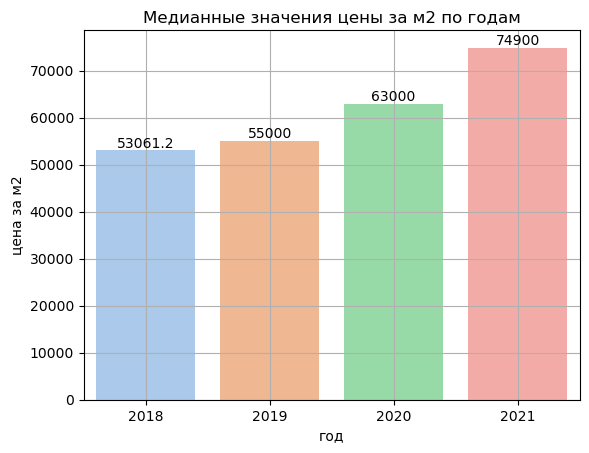

In [232]:
year_report = df.pivot_table(index=df['pur_year'], aggfunc='median', values='price_per_m2').reset_index()

ax = sns.barplot(data=year_report,
            x='pur_year',
            y='price_per_m2'
           )

ax.bar_label(ax.containers[0])

plt.title('Медианные значения цены за м2 по годам')
plt.ylabel('цена за м2')
plt.xlabel('год')
plt.grid()
plt.show()

Наблюдаем рост медианного значения цены за м2 с каждым годом. Ситуацию в целом понятна и ожидаема, попробуем выявить какие-то закономерности в рамках каждого года

In [246]:
df['pur_year'].unique()

array([2018, 2019, 2020, 2021], dtype=int64)

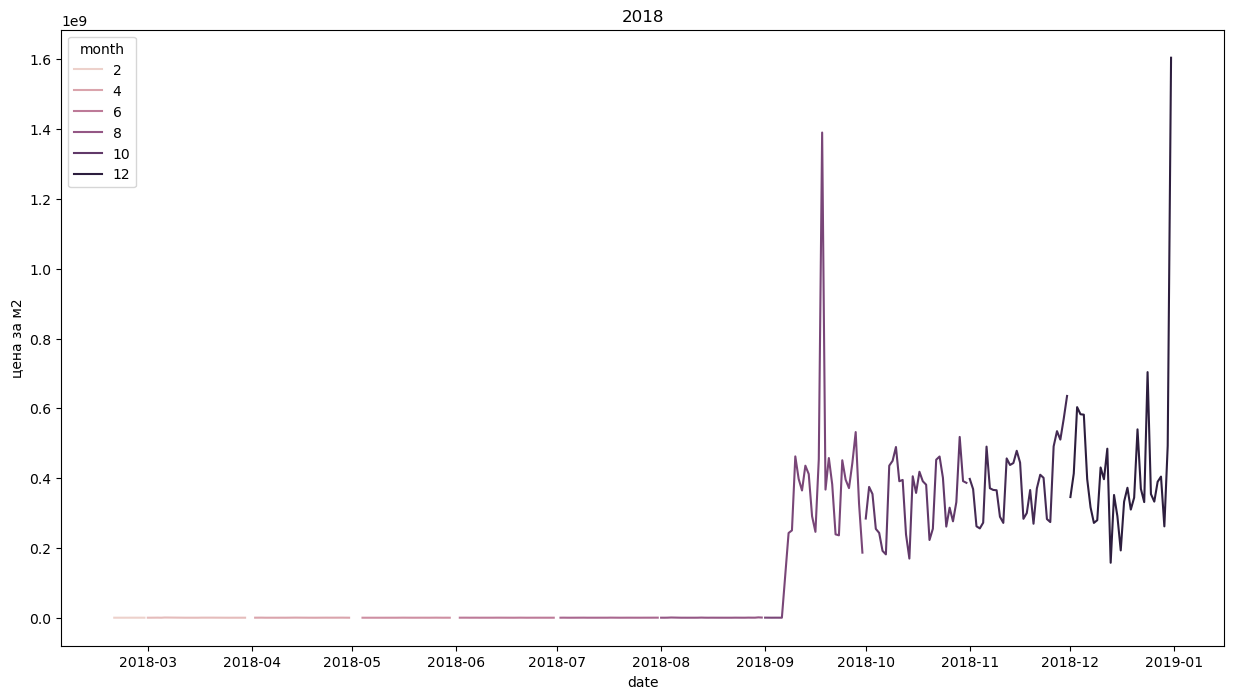

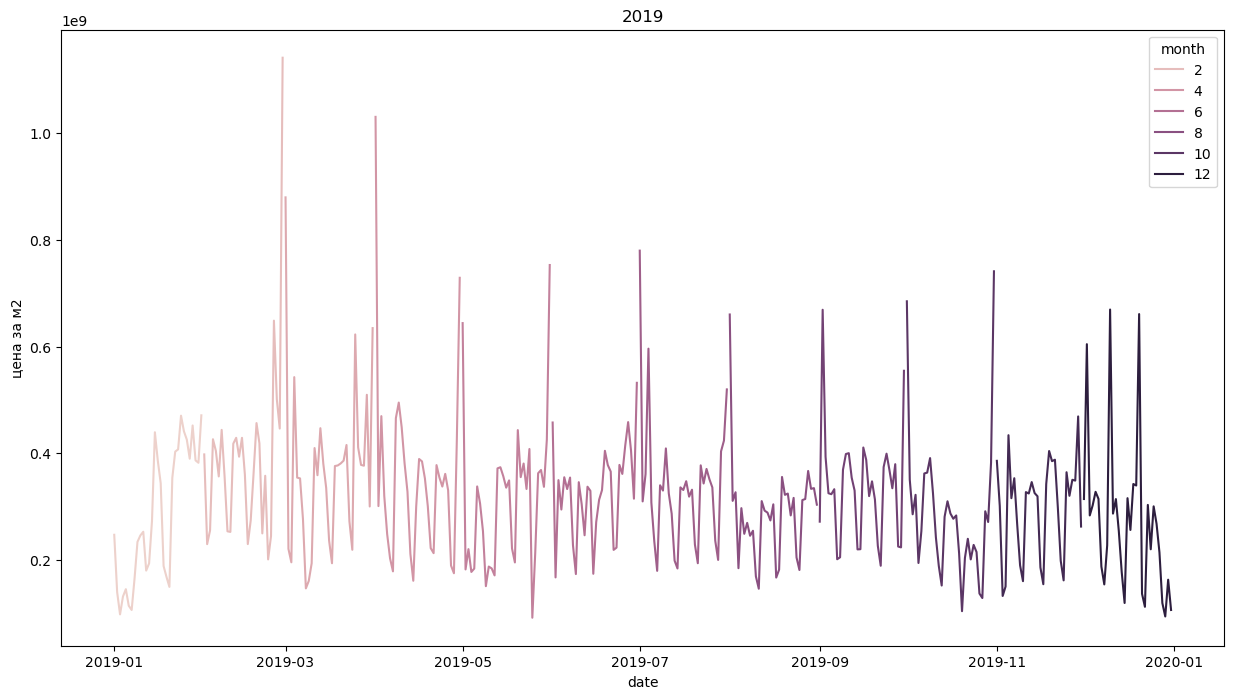

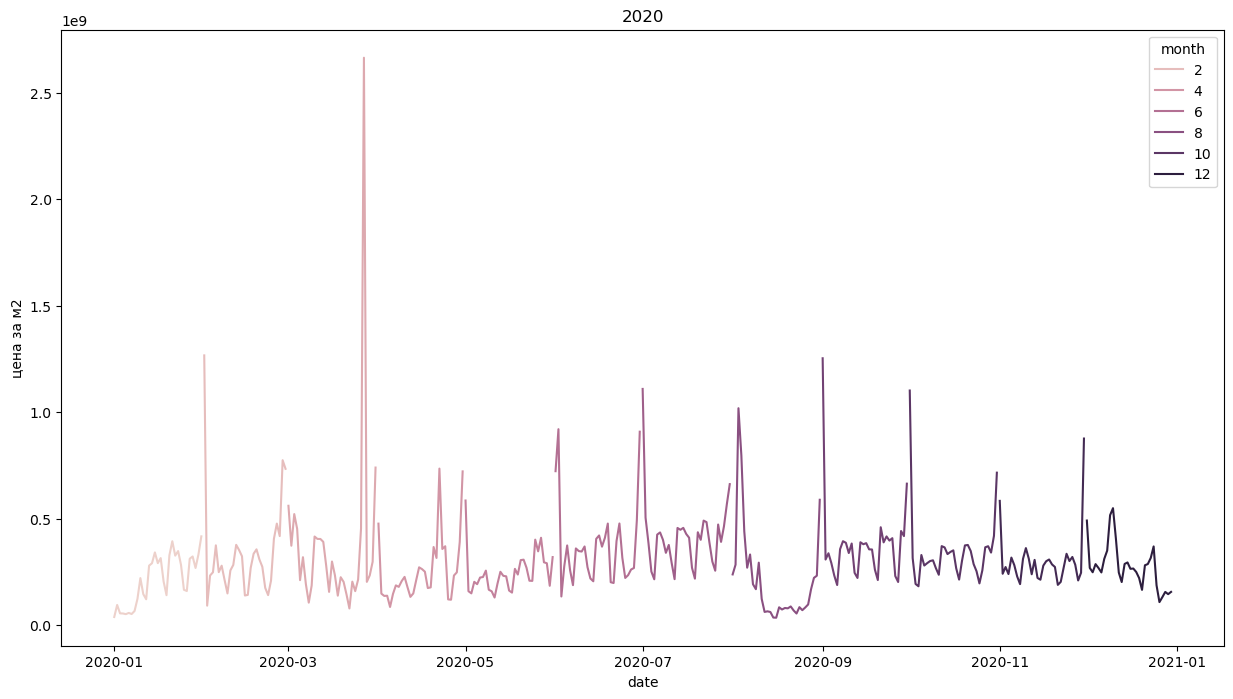

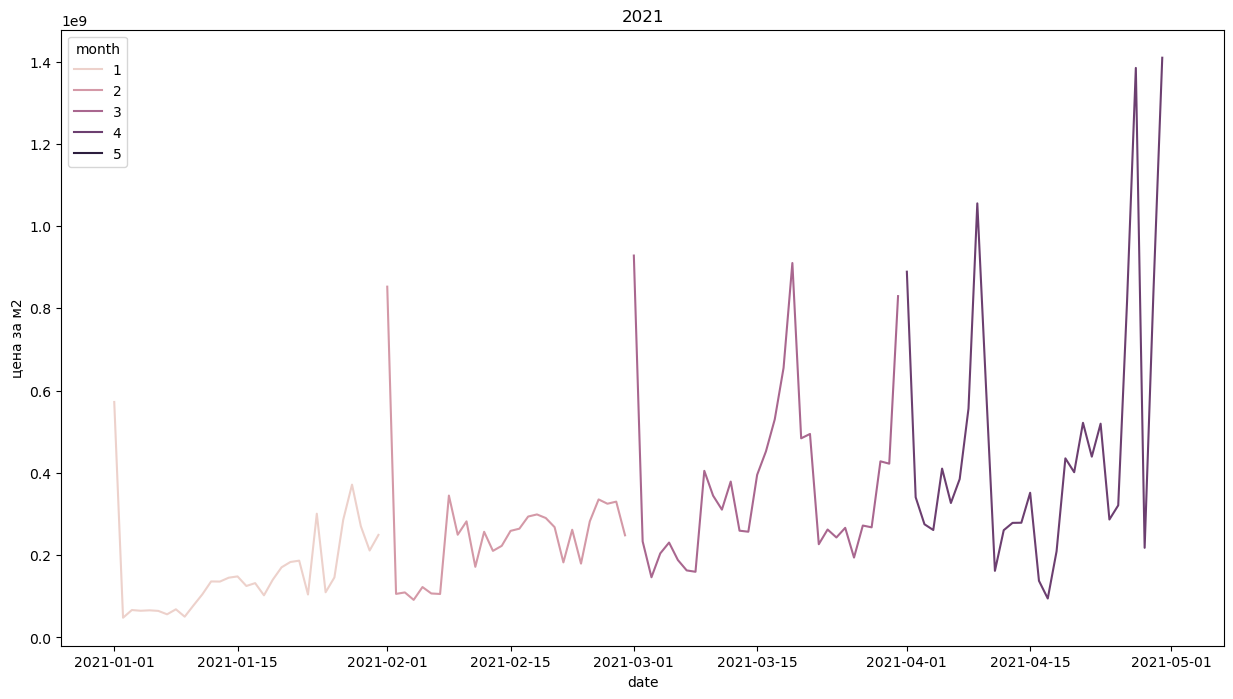

In [254]:
for i in list(df['pur_year'].unique()):
    report = df[df['pur_year'] == i]
    
    #визуализируем
    sns.set_palette('pastel')
    plt.figure(figsize=(15,8))
    sns.lineplot(data=report, 
             x='date', 
             y='price_per_m2', 
             hue='month', 
             ci=None, 
             estimator='sum'
            )
    plt.title(i)
    plt.ylabel('цена за м2')
    plt.show()

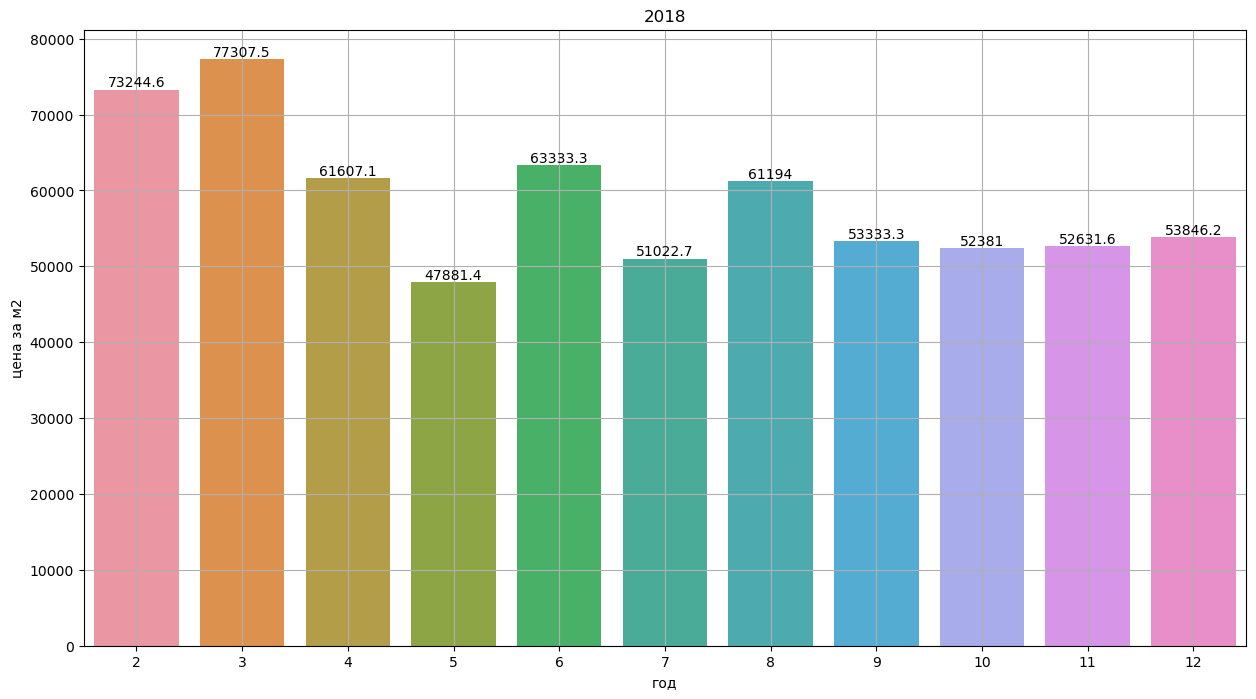

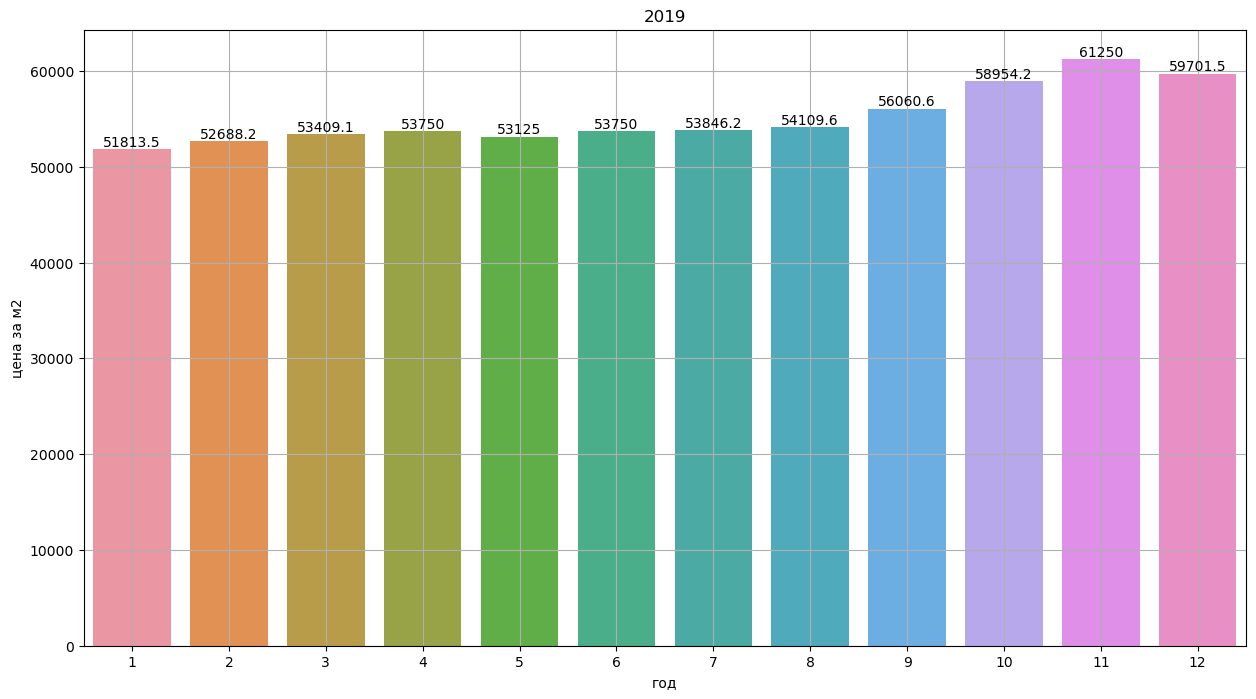

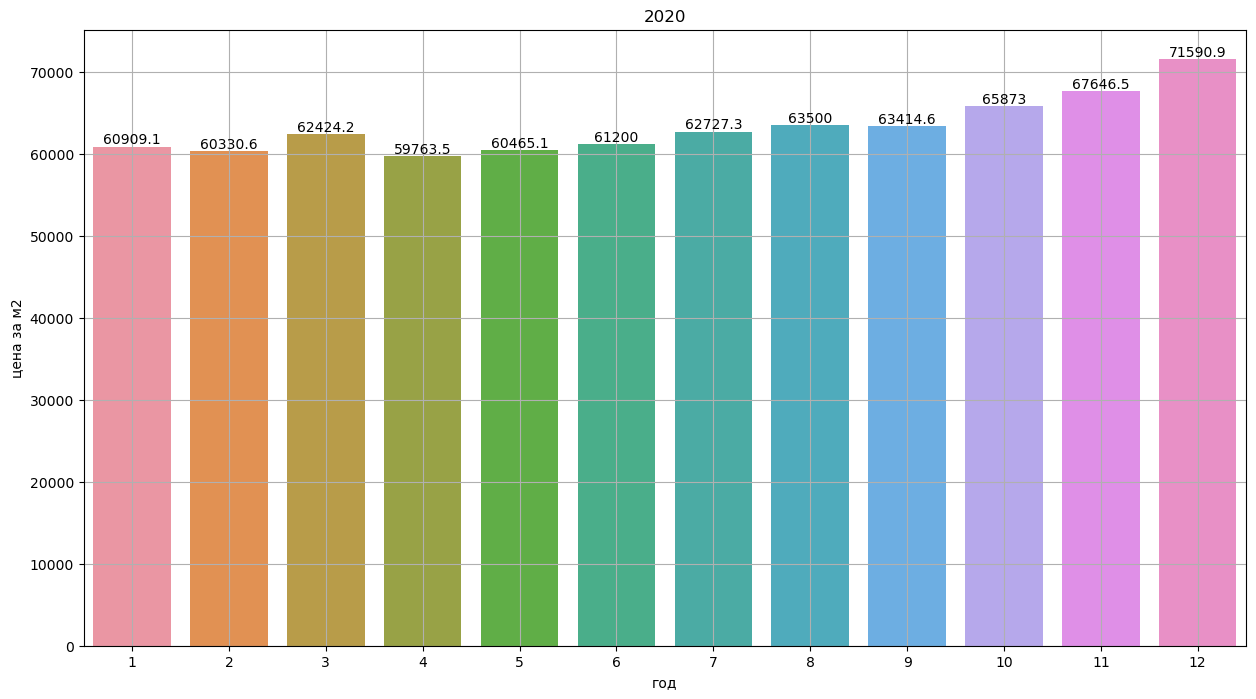

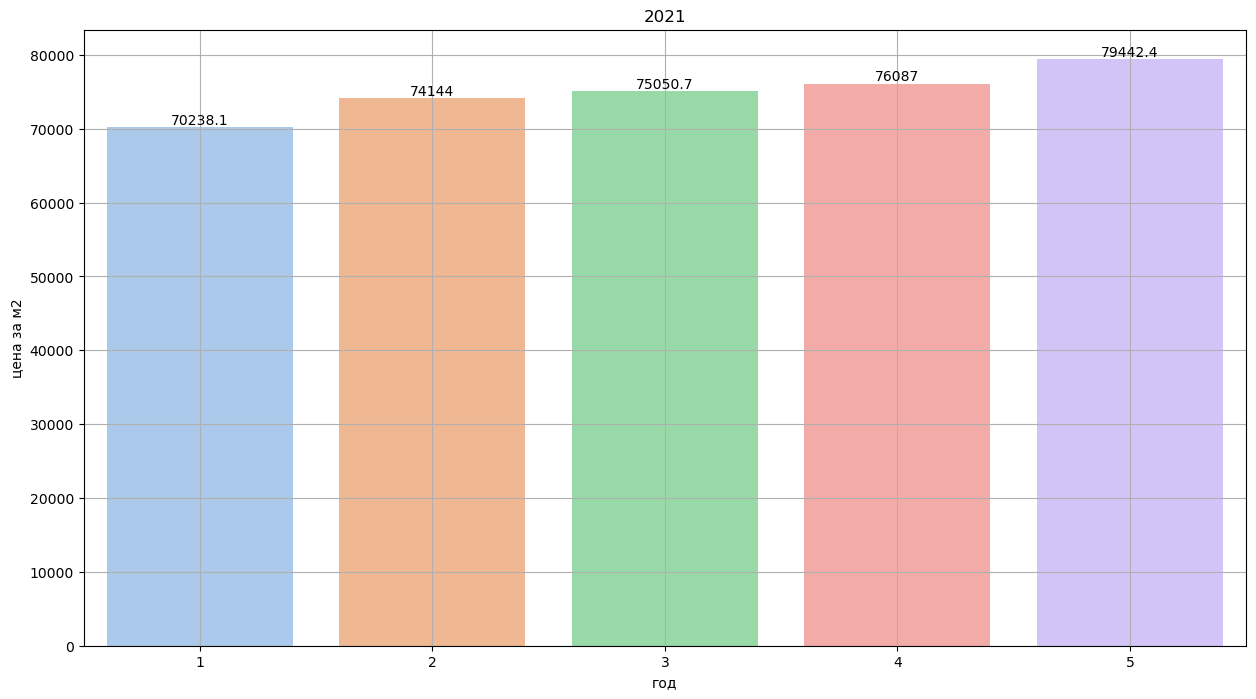

In [280]:
for i in list(df['pur_year'].unique()):
    report = df[df['pur_year'] == i]
    month_report = report.pivot_table(index=report['month'], aggfunc='median', values='price_per_m2').reset_index()

    plt.figure(figsize=(15,8))
    
    ax = sns.barplot(data=month_report,
                    x='month',
                    y='price_per_m2'
                    )

    ax.bar_label(ax.containers[0])

    plt.title(i)
    plt.ylabel('цена за м2')
    plt.xlabel('год')
    plt.grid()
    plt.show()

Сделаем выводы по каждому году:

### 2018 

    В 2018 году наблюдаются незначительные колебания цены за м2 от 77 тыс. ден.ед. до 48 тыс. ден. ед.. Самое больше значение медианной цены пришлось на март 2018 года, после этого момента цена начала падать, составив к концу году около 53 846.2 ден. ед. Это гвоорит о том, что к концу годы квартиры подешевели. Это могло произойти вследствии снижения спроса на жилью из-за фунтдаментальных проблем рынка недвижимости в 2018 году. Во-первых, это крах "Урбана" - одного из главных застройщиков в Подмосковье. Тема обманутых дольщиков встает всё острее на повестке дня, люди боятся вкладываться в недвижимости. (Далее в работе рассмотрим, как цена менялась в Подмосковье в 2018 году). Во-вторых, доверие россиян упало из-за судебных разбирательств крупнейшего строительного комплекса O1 Group.  

### 2019 

    В 2019 году наблюдается стабилизация ситуации на рынке недвижимоти. Медианная цена за м2 растет очень плавно с каждым месяцем. Колебания достаточно сдержанные. Такое изменение сопровождалось поддержкой государства. После кризисного 2018 года, с целью стимулирования спроса на недвижимость, была снижена ключевая ставка ЦБ (не только из-за рынка недвижимости), что сделало ипотеки более доступными и дешевыми. Были попытки также исправить проблему обманутых дольщиков введением эксроу-счетов. Фактически с этого момента долевое строительство запрещено, теперь возможно только проектное финансирование и продажа квартир через эскроу-счетов. Эта поправка защищает покупателей от рисков, связанных с задержкой получения квартиры, однако для застройщиков это означает, что теперь стройка осуществляется не за счет бесплатных средств дольщиков, а за счет обеспечения ее кредитными средствами банка. Поэтому введение эскроу-счетов означает только одно - увеличение стоимости квадратного метра, так как застройщикам теперь нет необходимости продавать квартиры дешево на начальных этапах стройки.

### 2020 

    Из-за пандемии COVID 2020 год оказался очень сложным для экономики страны, строительная отрасть не исключение. Наблюдается резкий рост цена за м2 в апреле 2020 года, а потом резкое падение цены. Также наблюдается снижение цена за м2 в конце августа, однако уже к середине сентября ситуация стабилизровалась. Если смотреть на картину в общем, то в апреле 2020 года медианная цена за м2 снизиламь, но незначительно. На протяжении всего года наблюдается постепенное увеличение цена за м2, в декабре 2020 года цена достигает своего максимума и составляет  71 591 ден. ед. за м2. С чем связаны такие изменения? 
    Во время локдауна многие застройщики приостановили работу с 13 апреля по 18 мая. В результате жилищное строительство снизилось на рекордные 30%, а застройщики были вынуждены обратиться за помощью к государству. Одной из главных мер антикризисной поддержки строительной отрасли в 2020 году стала программа льготной ипотеки, запущенная в апреле по поручению президента России Владимира Путина, чем и можно объяснить стабилизацию ситуации. 

### 2021 

    Анализ ситуации на рынке недвижимости в 2021 году будет проводиться только по первому полугодию. По динамике цен можно сказать, что в апреле 2021 года начались резкие колебания цены за м2, хотя до это ситуация была +- стабильна. Также по графику видно, что начало каждого месяца сопровождается высокой ценой за м2. В медианном выражении цена за м2 росла в первом полугодии 2021 года. Этот рост обусловлен программой льготной ипотеки. Однако, ее влияние в 2021 году уже не было таким сильным, как во второй половине 2020 года, соответственно и рост не такой резкий. Рост цены за м2 в мае 2021 года может быть объяснен снижением до 5,55% годовых ставку по программе льготной ипотеки на новостройки при первоначальном взносе от 20% и при регистрации сделки в электронном виде. К июню 2021 года цена за м2 достигла своего максимума в медианном выражении за весь рассматриваемый период 2018-2021 гг. и составила 79 442 ден.ед.

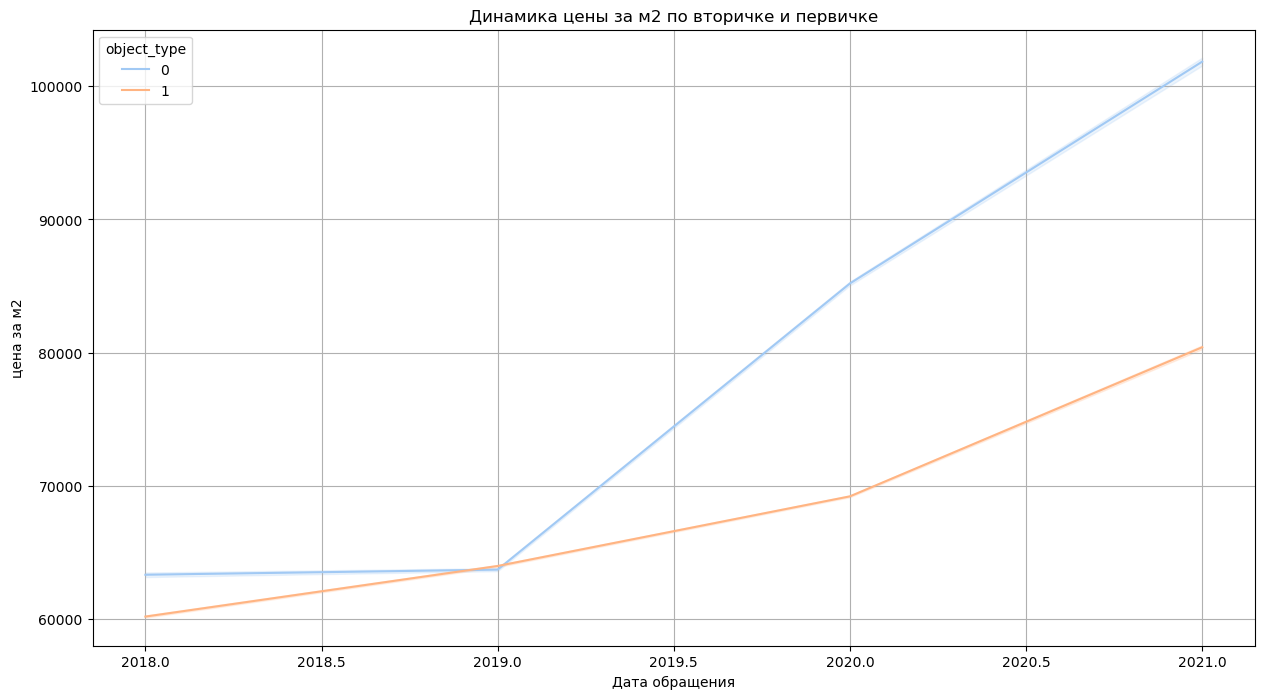

In [295]:
plt.figure(figsize=(15,8))
sns.lineplot(data=df, 
            x='pur_year', 
            y='price_per_m2', 
            hue='object_type')
    
plt.title('Динамика цены за м2 по вторичке и первичке')
plt.ylabel('цена за м2')
plt.xlabel('Дата обращения')
plt.grid()
plt.show()

Посмотрев динамику цены за м2 по рынкам первичного и вторичного, можно заметить интересную ситуацию. Стоимость первичного жилья до 2019 года чуть превышала стоимость вторичного жилья. После 2019 года этот разрыв резко увеличился. Цены на первичное жилье резко возросли из-за запуска программы льготного ипотечного кредитования. К 2023 году надулся пузырь, который вот-вот лопнет. ЦБ применяет меры, чтобы избежать данной ситуации. С 1 января 2024 года повышен размер первого взноса до 30%, повышена ключевая ставка, отменены некоторые льготы.

### Как менялась цена за м2 в зависимости от региона 

In [256]:
df['region'].nunique()

84

Для анализа представлено 84 региона РФ. Создадим свободную таблицу, содержащую медианные значения цены за м2.

In [297]:
region_report = df.pivot_table(index=df[['reg_name', 'object_type']], aggfunc='median', values='price_per_m2').reset_index()

Данных очень много. Посмотрим ТОП-5 регионов с самой большой ценой за м2 и ТОП-5 регионов с самой маленькой ценой

In [302]:
# ТОП-5 с самыми высокими ценами за м2
region_report_1 = region_report.sort_values('price_per_m2', ascending=False)

Text(0.5, 1.0, 'ТОП-5 регионов с наибольшей ценой за м2 за первичное жилье')

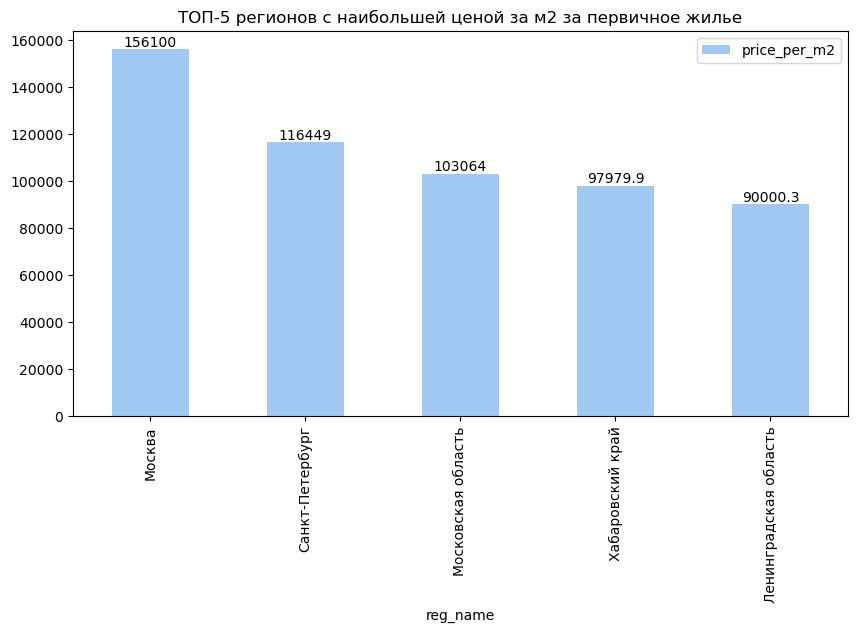

In [303]:
# визуализируем
ax = region_report_1.query("object_type == 0").head(5).plot(kind='bar', x='reg_name', y='price_per_m2', figsize=(10, 5), legend=True)

for container in ax.containers:
    plt.bar_label(container)
    
plt.title('ТОП-5 регионов с наибольшей ценой за м2 за первичное жилье')

Text(0.5, 1.0, 'ТОП-5 регионов с наибольшей ценой за м2 за вторичное жилье')

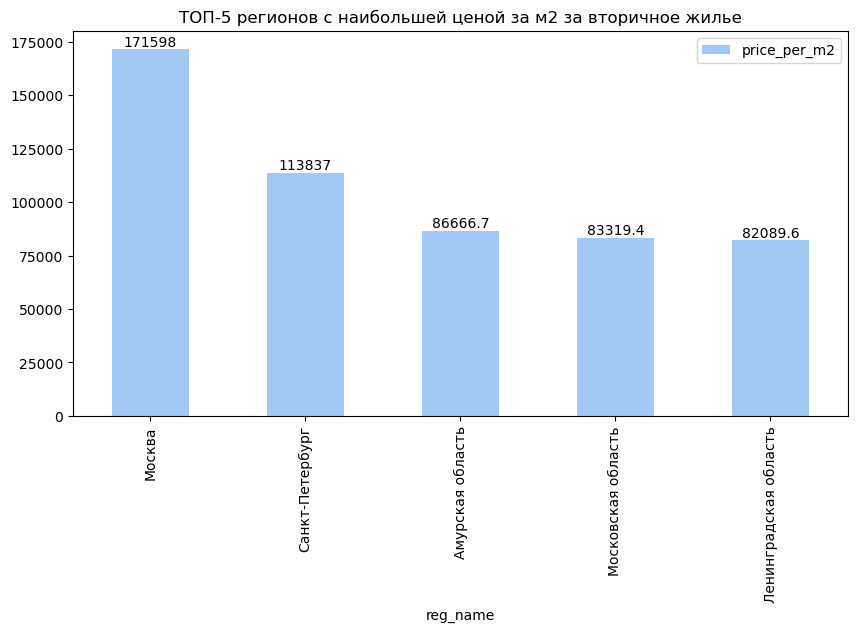

In [304]:
# визуализируем
ax = region_report_1.query("object_type == 1").head(5).plot(kind='bar', x='reg_name', y='price_per_m2', figsize=(10, 5), legend=True)

for container in ax.containers:
    plt.bar_label(container)
    
plt.title('ТОП-5 регионов с наибольшей ценой за м2 за вторичное жилье')

Самые высокие цены на недвижимость (и первичную, и вторичную) в столицах РФ, а именно в Москве и Санкт-Петербурге. Не исключением являются и области главнейших городов страны. Кроме того, в число регионов с самый высокой ценой за м2 по первичному жилью вошел Хабаровский край, а по вторичному жилью - Амурская область, они относятся к Дальнему Востоку, где сейчас наблюдается высокий спрос на недвижимость.

In [305]:
# ТОП-5 с самыми низкими ценами за м2
region_report_2 = region_report.sort_values('price_per_m2', ascending=True)

Text(0.5, 1.0, 'ТОП-5 регионов с наименьшей ценой за м2 за первичное жилье')

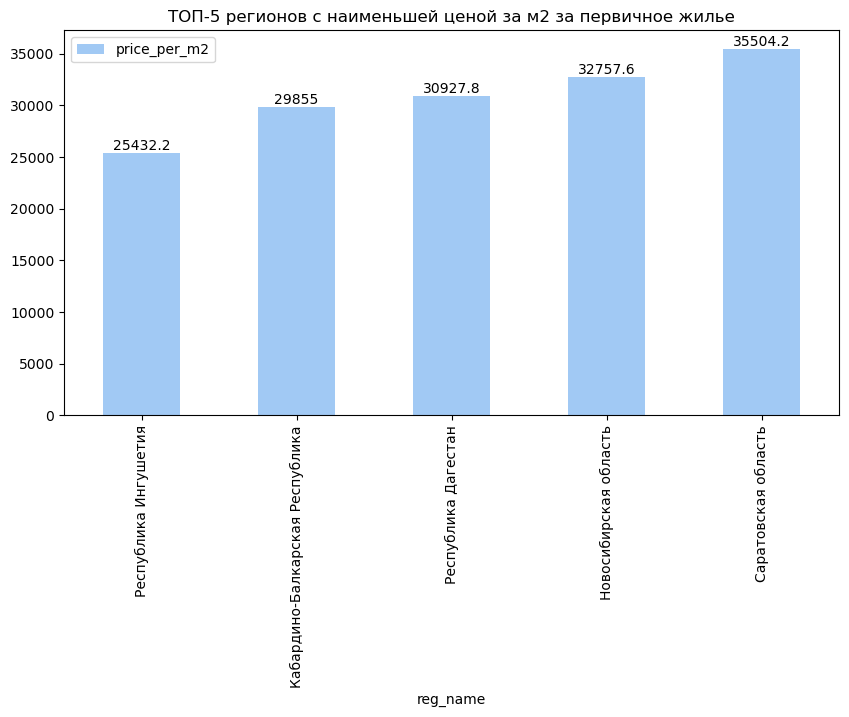

In [306]:
# визуализируем
ax = region_report_2.query("object_type == 0").head(5).plot(kind='bar', x='reg_name', y='price_per_m2', figsize=(10, 5), legend=True)

for container in ax.containers:
    plt.bar_label(container)
    
plt.title('ТОП-5 регионов с наименьшей ценой за м2 за первичное жилье')

Text(0.5, 1.0, 'ТОП-5 регионов с наибольшей ценой за м2 за вторичное жилье')

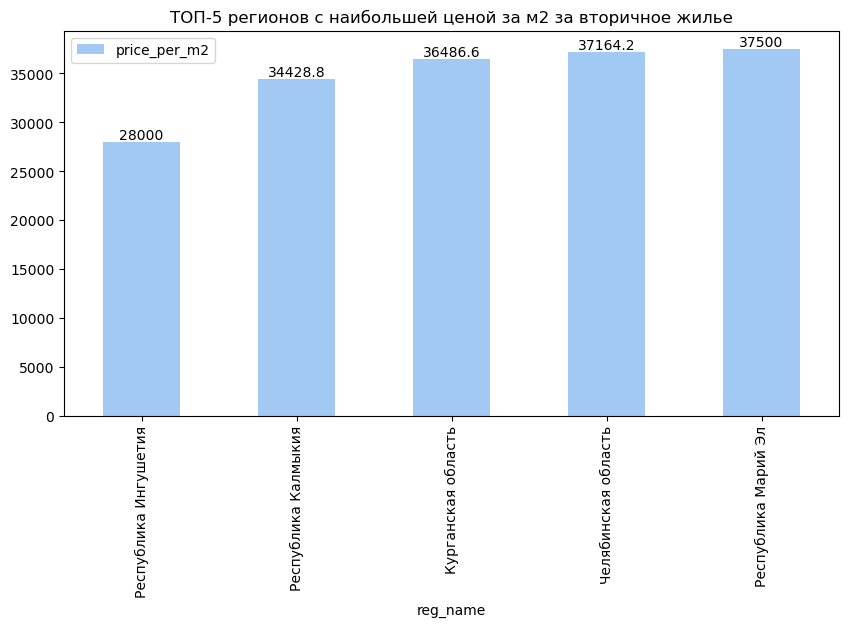

In [307]:
# визуализируем
ax = region_report_2.query("object_type == 1").head(5).plot(kind='bar', x='reg_name', y='price_per_m2', figsize=(10, 5), legend=True)

for container in ax.containers:
    plt.bar_label(container)
    
plt.title('ТОП-5 регионов с наибольшей ценой за м2 за вторичное жилье')

Лидером по дешевым квартирам стала Республика Ингушетия. Данный субъект является не только одним из самых удаленных, но и одним из самых бедных субъектов Российской Федерации, это подтверждает Росстат: "Росстат признал его городом с самым низким индексом стоимости жизни в России — товары и услуги на 25% дешевле среднестатистических". 

    При исследовании зависимости цены за м2 от региона можно сделать вывод о том, что цена за м2 выше в более развитых и современных регионах России. В Москве  цены за м2 достигает своего максимума, а вот в Ингушетии - минимума.

### Как менялась цена за м2 в зависимости от типа дома

In [281]:
building_report = df.pivot_table(index=df['building_type'], aggfunc='median', values='price_per_m2').reset_index()
building_report = building_report.sort_values('price_per_m2', ascending=False)

Для удобства восприятия информации заменим нумерацию типа дома по ключам.

In [282]:
type_dict = {0: 'Другое', 1:'Панельный', 2:'Кирпично-монолитный', 3: 'Кирпичный', 4: 'Блочный', 5: 'Деревянный'}
building_report['building_type'] = building_report['building_type'].replace(type_dict)

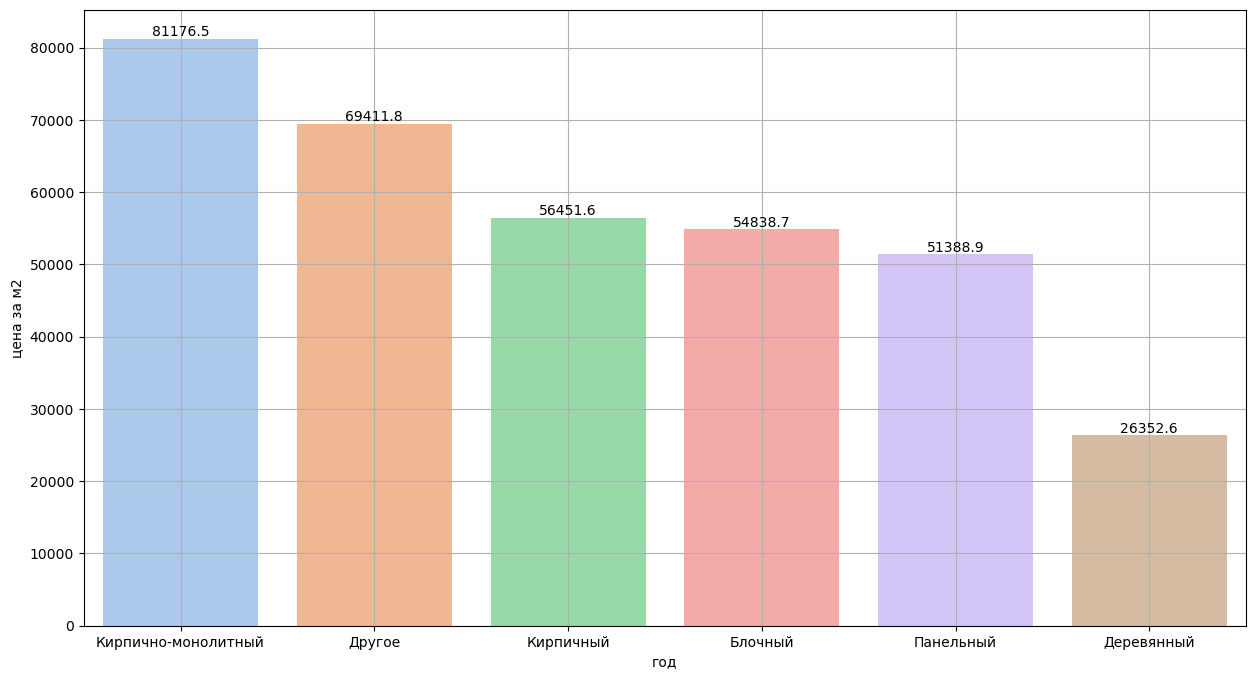

In [283]:
plt.figure(figsize=(15,8))

ax = sns.barplot(data=building_report,
                x='building_type',
                y='price_per_m2'
                )

ax.bar_label(ax.containers[0])

plt.figsize=(10, 5)
plt.ylabel('цена за м2')
plt.xlabel('год')
plt.grid()
plt.show()

Самая высокая цена за м2 в кирпично-монолитных домах, так как в силу физических свойств кипича такие дома имеют более высокое качество строительства, обладают лучшей звукоизоляцией и теплоизоляцией по сравнению с другими  типами домов, а также являются более безопасными. В кирпичных домах обычно больше шансов выдержать стихийные бедствия, такие как землетрясения или ураганы, что может быть важным фактором в некоторых регионах.

Низкая цена за м2 в деревянных домах объясняется низкой себестоимостью строительства деревянного дома, низким уровнем шумо  и теплоизоляции и низкой прочностью таких домов. 

    В целом, различия цен за м2 в разных типах домой обусловлены себестоимостью материалов для строительства и их 
    физическими свойствами.

### Как менялась цена за м2 в зависимости от этажа квартиры 

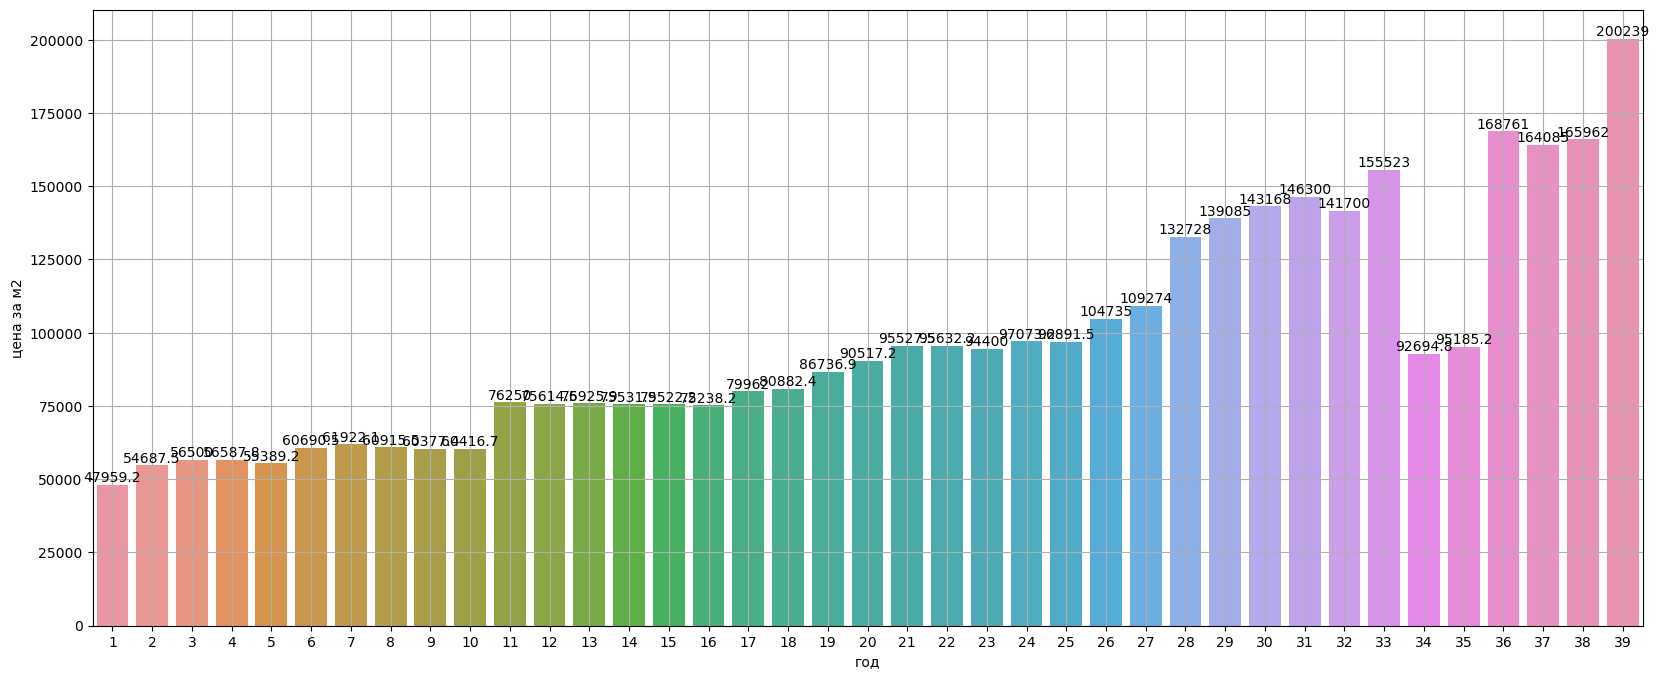

In [287]:
level_report = df.pivot_table(index=df['level'], aggfunc='median', values='price_per_m2').reset_index()

plt.figure(figsize=(20,8))

ax = sns.barplot(data=level_report,
                x='level',
                y='price_per_m2'
                )

ax.bar_label(ax.containers[0])

plt.figsize=(10, 5)
plt.ylabel('цена за м2')
plt.xlabel('год')
plt.grid()
plt.show()

Как видно из графика, чем выше этаж квартиры, тем выше цена за м2. Квартиры на верхних этажах обычно открывается панорамный вид на окружающий город или природу, они также обычно получают больше естественного света и меньше шума от улицы. Самые дешевые квартиры на первом этаже.

## Определите от каких признаков зависит стоимость объекта недвижимости. Найдите скрытые закономерности.

In [311]:
df.corr(method='spearman')['price']

price            1.000000
region          -0.355316
building_type   -0.008157
level            0.262125
levels           0.389965
rooms            0.330006
area             0.446121
kitchen_area     0.393826
object_type     -0.056659
median_per      -0.282214
price_per_m2     0.798784
pur_year         0.178983
month           -0.020680
Name: price, dtype: float64

Корреляция между ценой и другими переменными небольшая. Наибольшая корреляция наблюдается между ценой и и площадью квартиры. Также, есть зависимость между ценой и регионом, ценой и этажом квартиры/дома, ценой и годом продажи. Данные метрики уже были исследованы в том или ином виде в прошлых пунктах. Попробуем выявить скрытые закономерности.

## Скрытые закономерности

Миф заключается в том, что цена на первом и последнем этаже ниже, чем на других этажах. На рынке вторичной недвижимости это кажется логичным. Но на рынке первичной недвижимости, кажется, что цена на последнем этаже не будет отличаться от цен квартир на других этажах, более того она будет ниже. Проверим наши гипотезы.

In [316]:
first_level = df.query("level == 1")
first_level.head(1)

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type,median_per,reg_name,price_per_m2,pur_year,month,first_level
9,4500000,2018-07-04,2661,1,1,6,3,68.0,8.3,1,0.142857,Санкт-Петербург,66176.470588,2018,7,1.0


In [317]:
# добавим столбец-фильтр, чтобы определять на последнем этаже находится квартира или нет
for i in range(len(df['price'])):
    if df['level'].iloc[i] == df['levels'].iloc[i]:
        df.loc[i, 'last_level'] = 1;
    else:
        df.loc[i, 'last_level'] = 0

In [318]:
last_level = df.query("last_level == 1")
last_level.head(1)

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type,median_per,reg_name,price_per_m2,pur_year,month,first_level,last_level
3,6500000,2018-04-23,2661,3,3,3,3,89.0,10.0,1,0.142857,Санкт-Петербург,73033.707865,2018,4,0.0,1.0


    Гипотеза 1

Цена за квартиру на первом этаже меньше и в новостройках, и во вторичках

Исходя из сделанных ранее выводов о том, что распределение не явялется нормальным, будем использовать непараметрический тест Уилкоксона-Манна-Уитни, который устойчив к выбросам и к распределению.

In [321]:
# H0: cредняя цена квартиры на первом этаже и на других этажах одинакова
# H1: cредняя цена квартиры на первом этаже НИЖЕ, чем цена квартиры на других этажах

alpha = 0.05

results = st.mannwhitneyu(df.query("level != 1")['price'], first_level['price'])

print('p-value', results.pvalue / 2)

if results.pvalue / 2 < alpha and first_level['price'].mean() < df.query("level != 1")['price'].mean():
    print('Отклоняем нулевую гипотезу. Cредняя цена квартиры на первом этаже НИЖЕ, чем цена квартиры на других этажах')
else:
    print('Нет оснований отклонить нулевую гипотезу. Cредняя цена квартиры на первом этаже и на других этажах одинакова.')

p-value 0.0
Отклоняем нулевую гипотезу. Cредняя цена квартиры на первом этаже НИЖЕ, чем цена квартиры на других этажах


Гипотеза 1 доказана. Цена за квартиру на первом этаже МЕНЬШЕ.

    Гипотеза 2

Цена за квартиры на последнем этаже во вторичке МЕНЬШЕ, чем цена за квартиру на других этажах во вторичках

In [336]:
# H0: cредняя цена квартиры на последнем этаже и на других этажах одинакова во вторичках
# H1: cредняя цена квартиры на послежнем этаже НИЖЕ, чем цена квартиры на других этажах во вторичках

alpha = 0.05

sample_1 = df.query("last_level != 1 and object_type == 1")['price']
sample_2 = last_level.query("object_type == 1")['price']

results = st.mannwhitneyu(sample_2, sample_2)

print('p-value', results.pvalue / 2)

if results.pvalue / 2 < alpha and sample_2.mean() < sample_2.mean():
    print('Отклоняем нулевую гипотезу. Cредняя цена квартиры на послежнем этаже НИЖЕ, чем цена квартиры на других этажах во вторичках')
else:
    print('Нет оснований отклонить нулевую гипотезу. Cредняя цена квартиры на последнем этаже и на других этажах одинакова во вторичках')

p-value 0.5
Нет оснований отклонить нулевую гипотезу. Cредняя цена квартиры на последнем этаже и на других этажах одинакова во вторичках


In [337]:
# H0: cредняя цена квартиры на последнем этаже и на других этажах одинакова во вторичках
# H1: cредняя цена квартиры на последнем этаже и на других этажах  НЕ одинакова во вторичках

alpha = 0.05

sample_1 = df.query("last_level != 1 and object_type == 1")['price']
sample_2 = last_level.query("object_type == 1")['price']

results = st.mannwhitneyu(sample_2, sample_2)
print('p-value', results.pvalue)

if results.pvalue < alpha:
    print('Отклоняем нулевую гипотезу')
else:
    print('Нет оснований отклонить нулевую гипотезу')

p-value 1.0
Нет оснований отклонить нулевую гипотезу


Гипотеза 2 не подтвердилась не по одностороннему тесту, не по двустроннему. Средняя цена квартиры на последнем этаже не отличается от цены квартиры на других этажах во вторичках.

Какая ситуация в новостройках?

Совеременные новостройки построены немного по другому плану. На верхних этажах часто располагают двухэтажные, элитные квартиры, с великолепным панорамным видом и большими балконами с выходом на крышу. В таком случае можно предположить, что цена квартиры на последнем этаже в новостройках не просто не будет НИЖЕ, а будет, возможно, даже выше. Проверим это.

    Гипотеза 3

Цена квартиры на последнем этаже в новостройке выше, чем цена квартиры на других этажах.

In [340]:
# H0: cредняя цена квартиры на последнем этаже и на других этажах одинакова в новостройках
# H1: cредняя цена квартиры на послежнем этаже ВЫШЕ, чем цена квартиры на других этажах в новостройках

alpha = 0.05

sample_1 = df.query("last_level != 1 and object_type == 0")['price']
sample_2 = last_level.query("object_type == 0")['price']

results = st.mannwhitneyu(sample_2, sample_2)

print('p-value', results.pvalue / 2)

if results.pvalue / 2 < alpha and sample_2.mean() >= sample_2.mean():
    print('Отклоняем нулевую гипотезу. Cредняя цена квартиры на послежнем этаже НИЖЕ, чем цена квартиры на других этажах в новостройках')
else:
    print('Нет оснований отклонить нулевую гипотезу. Cредняя цена квартиры на последнем этаже и на других этажах одинакова в новостройках')

p-value 0.5
Нет оснований отклонить нулевую гипотезу. Cредняя цена квартиры на последнем этаже и на других этажах одинакова в новостройках


In [338]:
# H0: cредняя цена квартиры на последнем этаже и на других этажах одинакова в новостройках
# H1: cредняя цена квартиры на последнем этаже и на других этажах  НЕ одинакова в новостройках

alpha = 0.05

sample_1 = df.query("last_level != 1 and object_type == 0")['price']
sample_2 = last_level.query("object_type == 0")['price']

results = st.mannwhitneyu(sample_2, sample_2)
print('p-value', results.pvalue)

if results.pvalue < alpha:
    print('Отклоняем нулевую гипотезу')
else:
    print('Нет оснований отклонить нулевую гипотезу')

p-value 1.0
Нет оснований отклонить нулевую гипотезу


Наша гипотеза и здесь не подтвердилась двустронним/одностронним тестом. Получается, что в новостройках, также как и в старых домах квартиры на последнем этаже не дешевле, чем квартиры на других этажах.

## Вывод

Существует зависимость стоимости квартиры от года приобретения, региона, общей площади квартиры, количества комнат, этажности дома, этажа, на котором находится квартира. Была реализована попытка выявления скрытой закономерности, которая заключалась в зависимости цены квартиры от того, на первом этаже она находится или на последнем, учитывая при этом тип объекта: новостройка или вторичка. В результате, получилось, что средняя цена квартиры и в новых, и во вторичных кввартирах на первом этаже НИЖЕ, чем на других этажах. Что нельзя сказать о последнем этаже. Квартиры на последнем этаже в новостройках, и во вторички стоят столько же, сколько квартиры на других этажах. Эти выводы были доказаны статистическими тестами. 

##  Когда выгодно покупать/продавать объект недвижимости?

In [343]:
df.head()

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type,median_per,reg_name,price_per_m2,pur_year,month,first_level,last_level
0,6050000,2018-02-19,2661,1,8,10,3,82.6,10.8,1,0.142857,Санкт-Петербург,73244.552058,2018,2,0.0,0.0
1,3600000,2018-03-04,2661,1,2,5,1,31.1,6.0,1,0.257732,Санкт-Петербург,115755.627010,2018,3,0.0,0.0
2,3200000,2018-04-10,2661,1,7,9,1,31.0,7.0,1,0.257732,Санкт-Петербург,103225.806452,2018,4,0.0,0.0
3,6500000,2018-04-23,2661,3,3,3,3,89.0,10.0,1,0.142857,Санкт-Петербург,73033.707865,2018,4,0.0,1.0
4,6300000,2018-04-28,2661,3,5,5,2,99.9,14.5,1,0.177215,Санкт-Петербург,63063.063063,2018,4,0.0,1.0


### Рынок вторичного жилья 

In [368]:
month = []
median_price = []

for i in range(1,13):
    data = df.query('month == @i and object_type == 1')
    median_price_1 = data['price_per_m2'].median()
    month.append(i)
    median_price.append(median_price_1)

df_price_1 = pd.DataFrame({'month': month, 'median_price': median_price})
df_price_1

,month,median_price
0,1,57750.759878
1,2,58823.529412
2,3,60944.334929
3,4,62121.212121
4,5,57358.271934
5,6,57575.757576
6,7,57777.777778
7,8,58333.333333
8,9,57844.690967
9,10,57777.777778


In [373]:
df_price_1.sort_values('median_price', ascending=False).head(1)

,month,median_price
3,4,62121.212121


In [374]:
df_price_1.sort_values('median_price', ascending=True).head(1)

,month,median_price
11,12,56456.456456


### Вывод 

Самая высокая медианная цена за м2 на рынке вторичного жилья наблюдается в апреле, соответсвенно, выгоднее всего продавать квартиру в апреле. Самая низкая медианная цена за м2 наблюдается в декабре, соответсвенно, выгоднее всего покупать квартиру в декабре.

### Рынок первичного жилья 

In [371]:
month = []
median_price = []

for i in range(1,13):
    data = df.query('month == @i and object_type == 0')
    median_price_1 = data['price_per_m2'].median()
    month.append(i)
    median_price.append(median_price_1)

df_price_0 = pd.DataFrame({'month': month, 'median_price': median_price})
df_price_0

,month,median_price
0,1,61153.442993
1,2,61739.130435
2,3,66752.119897
3,4,65583.119475
4,5,55384.615385
5,6,58000.000000
6,7,61231.128997
7,8,56368.715224
8,9,57777.777778
9,10,61409.992018


In [375]:
df_price_0.sort_values('median_price', ascending=False).head(1)

,month,median_price
11,12,70000.0


In [376]:
df_price_0.sort_values('median_price', ascending=True).head(1)

,month,median_price
4,5,55384.615385


### Вывод

Самая высокая медианная цена за м2 на рынке первичного жилья наблюдается в декабре, соответсвенно, покупать квартиру в декабре в новостройке НЕ стоит. Самая низкая медианная цена за м2 наблюдается в мае, соответсвенно, выгоднее всего покупать квартиру в мае.

## Покупка новой квартиры в Санкт-Петербурге

Так как мы живем в Санкт-Петербурге и будем покупать квартиру здесь (надеемся), то нам интересно как обстоит ситуация тут. Когда выгодно купить квартиру в новостройке в Санкт-Петеребурге?

In [379]:
month = []
median_price = []

for i in range(1,13):
    data = df.query('month == @i and object_type == 0')
    spb = df.query('reg_name == "Санкт-Петербург"')
    median_price_1 = data['price_per_m2'].median()
    month.append(i)
    median_price.append(median_price_1)

df_price_spb = pd.DataFrame({'month': month, 'median_price': median_price})
df_price_spb

,month,median_price
0,1,61153.442993
1,2,61739.130435
2,3,66752.119897
3,4,65583.119475
4,5,55384.615385
5,6,58000.000000
6,7,61231.128997
7,8,56368.715224
8,9,57777.777778
9,10,61409.992018


In [381]:
df_price_spb.sort_values('median_price', ascending=False).head(1)

,month,median_price
11,12,70000.0


In [380]:
df_price_spb.sort_values('median_price', ascending=True).head(1)

,month,median_price
4,5,55384.615385


### Вывод:

Если мы собираемся купить квартиру в новостройке в Санкт-Петеребурге, то выгоднее всего ее будет приобрести в мае, когда медитанная цена за м2 минимальна. Ни в коем случае не надо покупать квартиру перед новым годом в декабре. Можно переплатить и потерять деньги.

##  Создайте модель прогноза цены объекта недвижимости

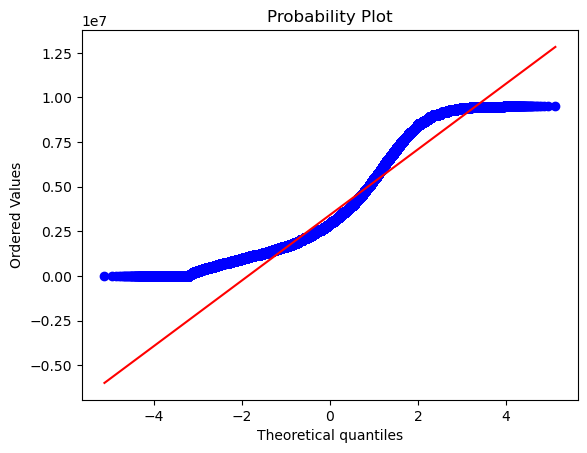

In [394]:
# построим QQ-plot
st.probplot(df['price'], dist='norm', plot=plt)
plt.show()

Исследуемый фактор - цена недвижимости не имеет нормального распределения, учтем это в дальнейшем.

In [387]:
corr_matrix = df.corr()

In [388]:
corr_matrix['price']

price            1.000000
region          -0.317715
building_type   -0.020500
level            0.260714
levels           0.384043
rooms            0.286347
area             0.272862
kitchen_area     0.163115
object_type     -0.072516
median_per      -0.272122
price_per_m2     0.675259
pur_year         0.160756
month           -0.018729
first_level     -0.049348
last_level      -0.115187
Name: price, dtype: float64

В качестве факторов множественной регрессии выберем те, у которых максимальная корреляция с полем price:
 1. region
 2. level
 3. levels
 4. rooms
 5. area
 
Построим модель используя Lasso() или Ridge() регуляризацию

In [419]:
# разделяем данные на признаки
x = df[[ 'region', 'level', 'levels', 'rooms', 'area']] 
y = df['price']

In [420]:
#разделяем данные на обучающую и валидационную выборку с random_state=13
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=13) 

In [421]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() # создаём объект класса scaler
scaler.fit(x) # обучаем стандартизатор

x_train_st = scaler.fit_transform(x_train)
x_test_st = scaler.transform(x_test)

Построим множественную линейную регрессии с помощью метода Лассо.

In [422]:
# создадим модель линейной регрессии
model = Lasso()

# обучим нашу модель
model.fit(x_train_st, y_train)

print(model.coef_, model.intercept_)

# делаем прогнозы
predictions = model.predict(x_test_st)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
r2_score(y_test, predictions)

[-519766.87307694    9099.10801592  735852.41757957  524491.36484038
  290094.75761983] 3419338.6058326466


0.3544996566055725

Коэффициент детерминации получился равен 0.354. А значит, 35,4% вариации y_test обусловлено вариацией predictions. Модель не совсем хорошо объясняет вариацию данных.
Попробуем применить Ridge-регрессию.

In [423]:
# создадим модель линейной регрессии
model = Ridge()

# обучим нашу модель
model.fit(x_train_st, y_train)

print(model.coef_, model.intercept_)

# делаем прогнозы
predictions = model.predict(x_test_st)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
r2_score(y_test, predictions)

[-519767.65905112    9099.16341087  735853.1617724   524492.03787318
  290095.38951353] 3419338.6058326466


0.35449966101363783

Коэффициент детерминации и коэффициенты при факторах остались +- такими, как и были. Данная модель не показала лучших результатов. 

Уравнение модели прогноза цены на недвижимость выглядит следующим образом:

## y = -519767,7 x1 + 9099,2 x2 + 735853,2 x3 + 524492 x4 + 290095,4 x5 + e
    где у - стоимость недвижимости
        х1 - регион 
        х2 - этаж, на котором расположена квартира
        х3 - этажность дома
        х4 - количество квадратных метров
        х5 - количество комнат

C:\Users\An_to\AppData\Local\Temp\ipykernel_11328\421924994.py:39: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],  "k--", color='r')


Text(0.5, 1.0, 'Предсказанные значения vs. Фактические значения')

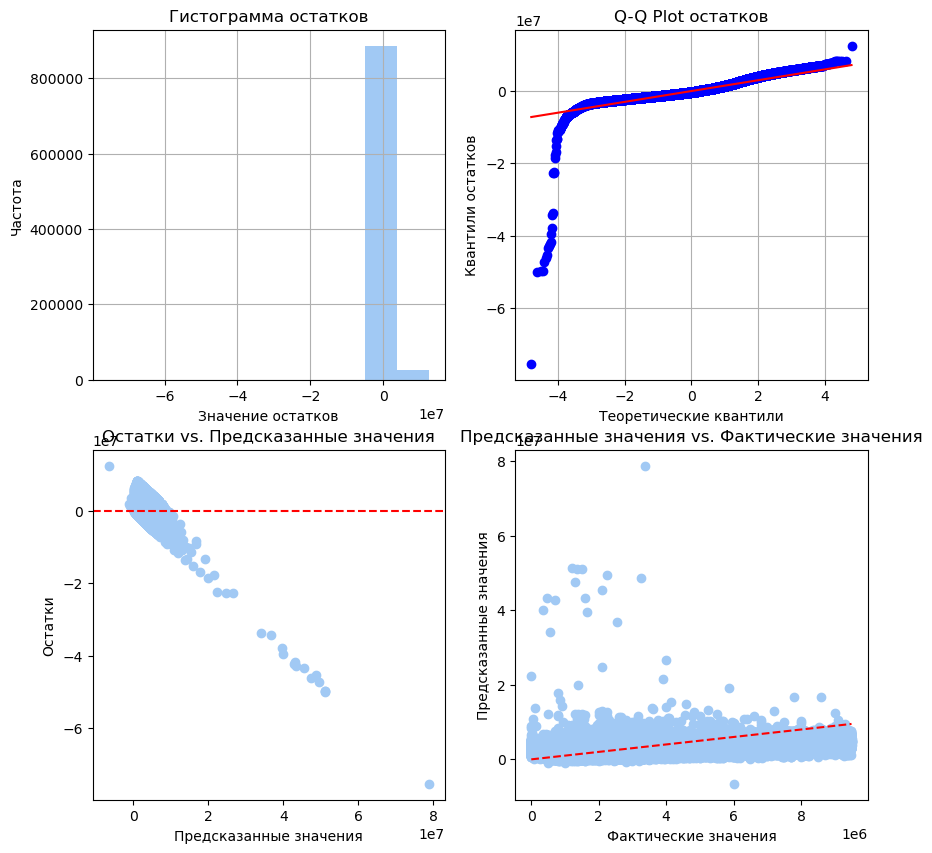

In [424]:
import statsmodels.api as sm

# Получение остатков модели
residuals = y_test - predictions

# Расчет стандартизированных остатков
stand_residuals = (residuals - np.mean(residuals)) / np.std(residuals)
plt.subplots(figsize=(10, 10))


# Распределение остатков
plt.subplot(2, 2, 1)
plt.hist(residuals)
plt.xlabel('Значение остатков')
plt.ylabel('Частота')
plt.title('Гистограмма остатков')
plt.grid(True)


# График остатков vs. предсказанных значений
plt.subplot(2, 2, 2)
st.probplot(residuals, dist='norm', plot=plt)
plt.xlabel('Теоретические квантили')
plt.ylabel('Квантили остатков')
plt.title('Q-Q Plot остатков')
plt.grid(True)

#График остатков относительно прогноза
plt.subplot(2, 2, 3)
plt.scatter(predictions, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('Остатки vs. Предсказанные значения')

# Предсказанные и фактические значения
plt.subplot(2, 2, 4)
plt.scatter(y_test, predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],  "k--", color='r')
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Предсказанные значения vs. Фактические значения')